In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression

from spineq.data_fetcher import get_oa_shapes, get_oa_centroids, get_la_shape
from spineq.plotting import plot_oa_weights, get_color_axis, plot_optimisation_result
from spineq.greedy import greedy_opt
from spineq.optimise import make_result_dict, optimise
from spineq.utils import coverage_matrix

import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
%matplotlib inline

In [2]:
lad20cd = "E08000037" #"E08000021"

## Space Syntax

In [3]:
ss = gpd.read_file("../data/raw/space_syntax/TyneandWear_geojson.geojson")
ss.rename(columns={"id": "ss_id"}, inplace=True)

In [4]:
# only keep space syntax segments intersecting or within local authority geometry
la = get_la_shape(lad20cd)

ss = ss[
    ss.crosses(la.geometry)
    | ss.within(la.geometry)
]

Text(0.5, 1.0, 'AC__NACH')

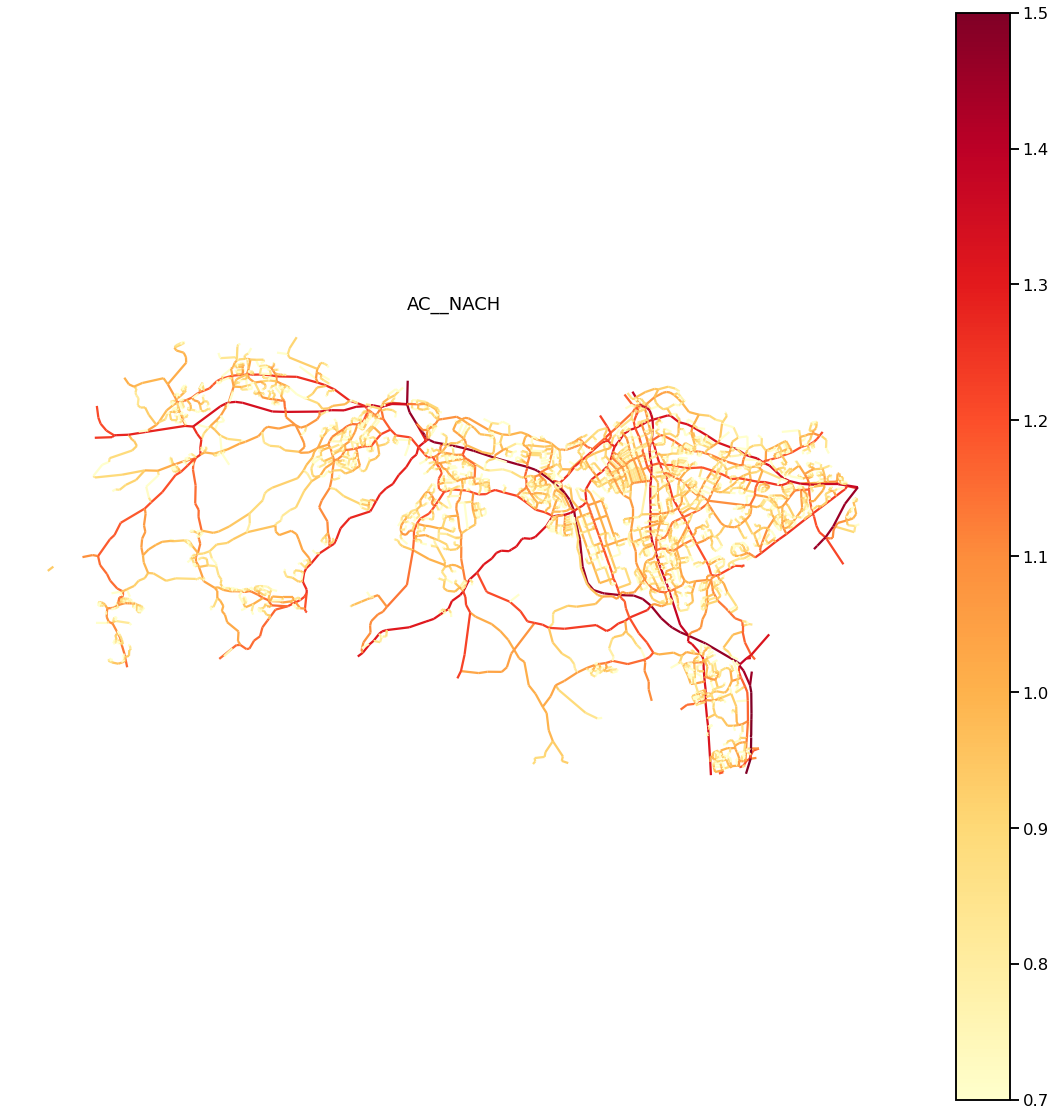

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ss.plot(column="AC__NACH", ax=ax, cmap="YlOrRd", legend=True, vmin=0.7, vmax=1.5)
ax.axis("off")
ax.set_title("AC__NACH")

<AxesSubplot:ylabel='Frequency'>

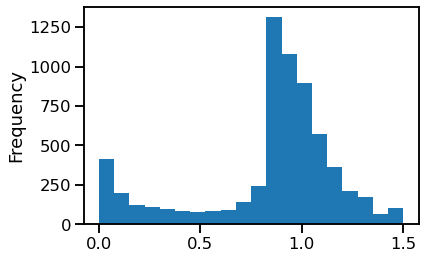

In [6]:
ss["AC__NACH"].plot.hist(bins=20)

## Raw DFT Traffic Data

In [7]:
dft = pd.read_csv("../data/raw/dft/dft_traffic_counts_aadf.csv")
display(dft.head())
len(dft)

,id,count_point_id,year,region_id,local_authority_id,road_name,road_category,road_type,start_junction_road_name,end_junction_road_name,...,buses_and_coaches,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,all_motor_vehicles
0,1,27294,2019,5,85,A560,PA,Major,LA Boundary,M56,...,391,2768,158,54,24,7,2,8,253,25927
1,2,1153,2019,3,30,A905,PA,Major,M9,M9 slip,...,35,1787,192,99,72,25,391,216,996,12959
2,3,8024,2019,9,80,M20,TM,Major,2,2,...,149,9592,1167,192,269,403,3799,1788,7619,55977
3,4,20505,2019,4,6,A48(M),TM,Major,LA Boundary,29A,...,276,5603,1052,140,230,106,508,1186,3222,47203
4,5,46628,2019,5,162,A62,PA,Major,A62 Manchester St roundabout,A627 King St,...,186,7242,629,152,152,37,120,196,1285,55089


489159

In [8]:
select_year = 2019
dft = dft[dft["year"] == select_year]
display(dft.head())
len(dft)

,id,count_point_id,year,region_id,local_authority_id,road_name,road_category,road_type,start_junction_road_name,end_junction_road_name,...,buses_and_coaches,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,all_motor_vehicles
0,1,27294,2019,5,85,A560,PA,Major,LA Boundary,M56,...,391,2768,158,54,24,7,2,8,253,25927
1,2,1153,2019,3,30,A905,PA,Major,M9,M9 slip,...,35,1787,192,99,72,25,391,216,996,12959
2,3,8024,2019,9,80,M20,TM,Major,2,2,...,149,9592,1167,192,269,403,3799,1788,7619,55977
3,4,20505,2019,4,6,A48(M),TM,Major,LA Boundary,29A,...,276,5603,1052,140,230,106,508,1186,3222,47203
4,5,46628,2019,5,162,A62,PA,Major,A62 Manchester St roundabout,A627 King St,...,186,7242,629,152,152,37,120,196,1285,55089


32904

In [9]:
dft = gpd.GeoDataFrame(dft, geometry=gpd.points_from_xy(dft["easting"], dft["northing"]),  crs="epsg:27700")
dft.rename(columns={"id": "dft_id"}, inplace=True)

In [10]:
dft = dft[
    dft.crosses(la.geometry)
    | dft.within(la.geometry)
]

display(dft)
len(dft)

,dft_id,count_point_id,year,region_id,local_authority_id,road_name,road_category,road_type,start_junction_road_name,end_junction_road_name,...,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,all_motor_vehicles,geometry
239,240,27818,2019,11,101,A189,PA,Major,A184,LA Boundary,...,5249,316,80,34,14,27,64,535,39208,POINT (424580.000 563000.000)
287,288,27484,2019,11,101,A184,PA,Major,A189,A814 to railway station,...,2498,224,50,34,25,68,69,470,17285,POINT (425000.000 563000.000)
366,367,57829,2019,11,101,A184,PA,Major,B1426,A167,...,2019,200,35,22,15,6,24,302,10420,POINT (425552.000 563000.000)
480,481,6735,2019,11,101,A184,PA,Major,A195 Sunderland Rd,LA Boundary,...,5409,513,110,126,49,90,289,1177,39096,POINT (430700.000 561420.000)
517,518,28776,2019,11,101,A1,TA,Major,A694 mid-junction,LA Boundary,...,11785,937,243,509,100,816,1316,3920,81022,POINT (419640.000 563050.000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110020,110021,951791,2019,11,101,U,MCU,Minor,NaN,NaN,...,141,4,2,0,0,1,1,7,774,POINT (415344.000 558292.000)
111618,111619,943365,2019,11,101,U,MCU,Minor,NaN,NaN,...,108,7,2,0,0,0,0,8,845,POINT (429989.000 561834.000)
113415,113416,943366,2019,11,101,U,MCU,Minor,NaN,NaN,...,21,0,0,0,0,0,0,0,123,POINT (413946.000 559579.000)
411247,411248,73518,2019,11,101,A194(M),TM,Major,A194M merge,LA Boundary,...,4763,599,104,237,46,393,684,2063,29357,POINT (428400.000 556416.000)


114

Text(0.5, 1.0, 'DfT Traffic Count Points')

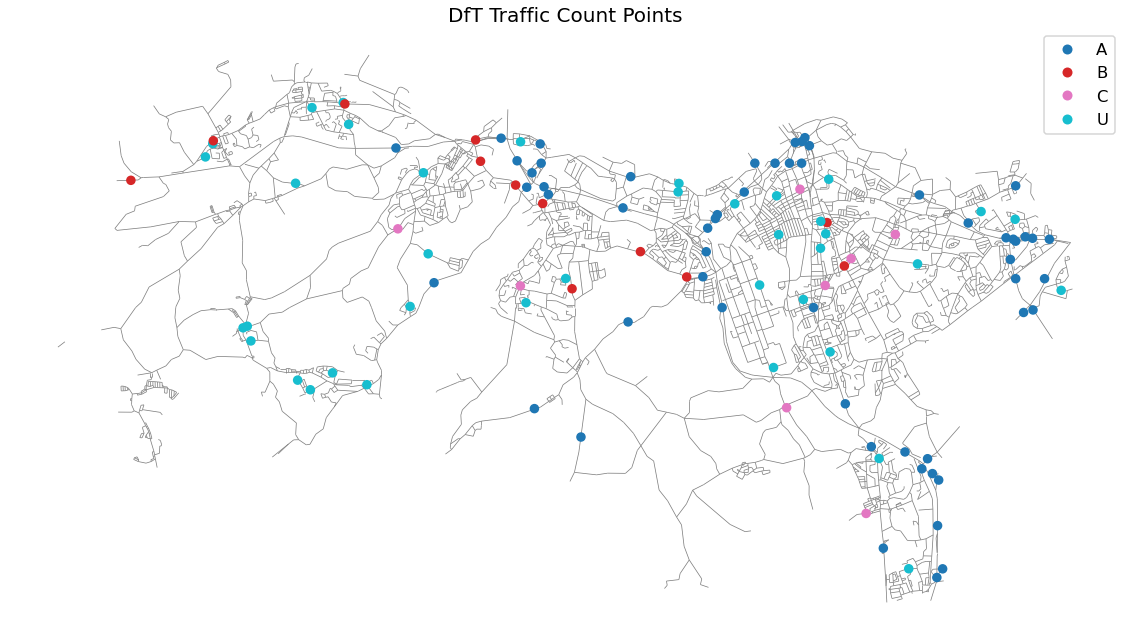

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ss.plot(ax=ax, zorder=1, color="gray", linewidth=0.75)
dft.plot(ax=ax, markersize=64, column=dft["road_name"].str[0], zorder=2, legend=True)
ax.axis("off")
ax.set_title("DfT Traffic Count Points", fontsize=20)

### Snap DFT points to nearest  lines (roads) in space syntax model

Following approach from:
- https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa


In [12]:
def match_dft_ss(
    dft: pd.DataFrame, ss: gpd.GeoDataFrame, offset: float = 10, tolerance: float = 50
) -> gpd.GeoDataFrame:
    """
    Find the line segments in the space syntax data ss that are closest to the
    traffic measurement points in dft.

    Inspired by https://medium.com/@brendan_ward/6113c94e59aa
    """
    ss.sindex  # Create spatial index (makes computation faster later)

    # all space syntax (ss) segments that intersect DfT measurement points
    # (within offset metres east/north of measurement point):
    bbox = dft.bounds + [-offset, -offset, offset, offset]
    hits = bbox.apply(lambda row: list(ss.sindex.intersection(row)), axis=1)

    # convert hits to flat list (row cotaining list of matches, to rows each
    # containing 1 match)
    hits = pd.DataFrame(
        {
            # index of point in dft
            "pt_idx": np.repeat(hits.index, hits.apply(len)),
            # index of line segment in ss
            "line_idx": np.concatenate(hits.values),
        }
    )

    # Join ss and dft based on matched indices
    hits = hits.join(ss.reset_index(drop=True), on="line_idx")
    hits = hits.join(dft.rename(columns={"geometry": "point"}), on="pt_idx")
    hits = gpd.GeoDataFrame(hits, geometry="geometry", crs=dft.crs)

    # calculate distances between points and matched line segments
    hits["snap_dist"] = hits.geometry.distance(gpd.GeoSeries(hits.point))
    # discard any hits with more than tolerance metres between dft point
    # and ss segment
    hits = hits.loc[hits.snap_dist <= tolerance]

    # Select closest dft point and ss segment match
    hits = hits.sort_values(by=["snap_dist"])
    closest = hits.groupby("pt_idx").first()

    return gpd.GeoDataFrame(closest, geometry="geometry")

In [13]:
dft_ss = match_dft_ss(dft, ss)
dft_ss.head()

,line_idx,fid,ss_id,metres,meridian_road_name,choice2km,choice2kmrank,choice2kmlog,nodecount2km,integration2km,...,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,all_motor_vehicles,point,snap_dist
pt_idx,,,,,,,,,,,,,,,,,,,,,
239,1778.0,415321,980808,307.876599,ST JAMES' BOULEVARD,25517.000000,0.846452,4.406847,977.0,264.831492,...,316,80,34,14,27,64,535,39208,POINT (424580.000 563000.000),1.130323
287,1767.0,415310,980797,587.143935,ASKEW ROAD,13846.833008,0.710962,4.141382,970.0,263.737908,...,224,50,34,25,68,69,470,17285,POINT (425000.000 563000.000),16.781234
366,1766.0,415309,980796,102.576800,CHARLES STREET,37065.832031,0.910739,4.568985,914.0,289.045932,...,200,35,22,15,6,24,302,10420,POINT (425552.000 563000.000),11.757044
480,1311.0,410257,975723,155.293271,None,7324.000000,0.848730,3.864808,268.0,81.156166,...,513,110,126,49,90,289,1177,39096,POINT (430700.000 561420.000),0.090152
517,458.0,397731,963026,333.917655,None,17517.250000,0.929958,4.243491,494.0,150.848141,...,937,243,509,100,816,1316,3920,81022,POINT (419640.000 563050.000),6.513582


<AxesSubplot:title={'center':'Space Syntax Segments with DfT Measurement'}>

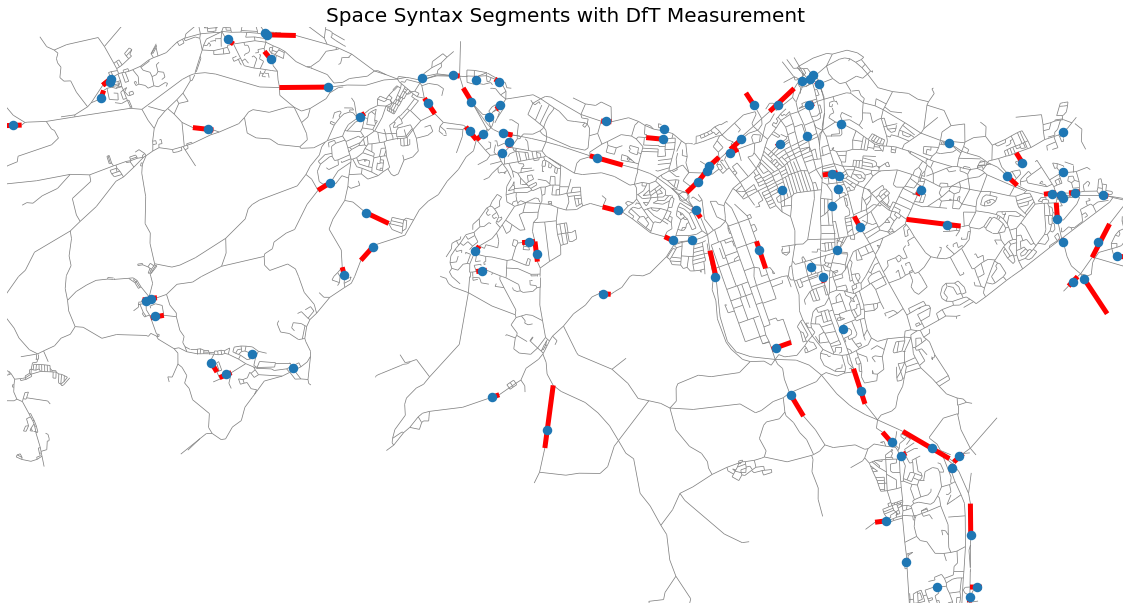

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ss.plot(ax=ax, zorder=1, linewidth=0.75, color="gray")
dft_ss.plot(ax=ax, zorder=2, color="r", linewidth=5)
ax.axis("off")
ax.set_title("Space Syntax Segments with DfT Measurement", fontsize=20)
border = 100
ax.set_xlim([dft["easting"].min() - border, dft["easting"].max() + border])
ax.set_ylim([dft["northing"].min() - border, dft["northing"].max() + border])
dft_ss["point"].plot(ax=ax, markersize=64, zorder=3)


/Users/jroberts/opt/anaconda3/envs/spatial-inequality/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'log[all_motor_vehicles]')

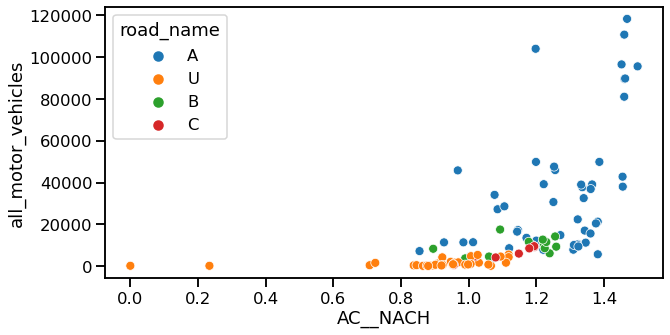

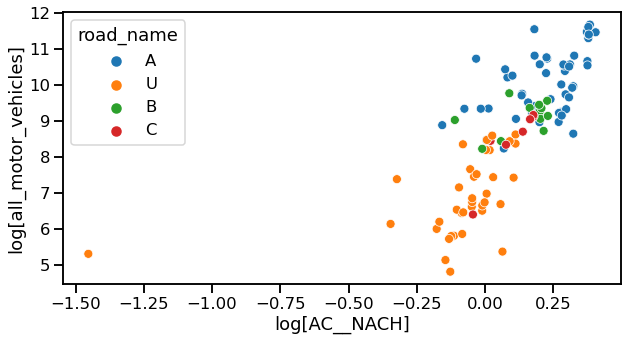

In [15]:
column = "AC__NACH"

plt.figure(figsize=(10, 5))
sns.scatterplot(
    x=dft_ss[column], y=dft_ss["all_motor_vehicles"], hue=dft_ss["road_name"].str[0]
)

plt.figure(figsize=(10, 5))
sns.scatterplot(
    x=np.log(dft_ss[column]),
    y=np.log(dft_ss["all_motor_vehicles"]),
    hue=dft_ss["road_name"].str[0],
)
plt.xlabel(f"log[{column}]")
plt.ylabel("log[all_motor_vehicles]")

In [16]:
print(np.corrcoef(dft_ss["AC__NACH"], dft_ss["all_motor_vehicles"]))
spearmanr(dft_ss["AC__NACH"], dft_ss["all_motor_vehicles"])

[[1.         0.57737161]
 [0.57737161 1.        ]]


SpearmanrResult(correlation=0.8112955763857675, pvalue=1.0759180821607867e-26)

8.2299293733192 [5.3438871]


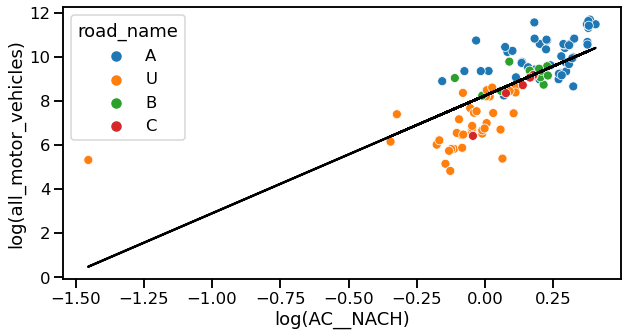

In [17]:
mask = (dft_ss["AC__NACH"] > 0) & (dft_ss["all_motor_vehicles"] > 0)

X = np.log(dft_ss[mask]["AC__NACH"]).values
y = np.log(dft_ss[mask]["all_motor_vehicles"])

mdl = LinearRegression()
mdl.fit(X.reshape(-1, 1), y)
print(mdl.intercept_, mdl.coef_)

y_pred = mdl.predict(X.reshape(-1, 1))
plt.figure(figsize=(10, 5))
plt.plot(X, y_pred, "k")
sns.scatterplot(x=X, y=y, hue=dft_ss[mask]["road_name"].str[0])
plt.xlabel("log(AC__NACH)")
plt.ylabel("log(all_motor_vehicles)")

resid = y_pred - y
dft_ss.loc[mask, "resid"] = resid
dft_ss.loc[mask, "pred"] = np.exp(y_pred)


In [18]:
dft_ss["abs_resid"] = dft_ss["resid"].abs()

print("PRED (SYNTAX) > ACTUAL (DFT)")
display(dft_ss.sort_values(by="resid", ascending=False)[
    ["road_name", "road_type", "all_motor_vehicles", "pred", "resid"]
].head(15))

print("PRED (SYNTAX) < ACTUAL (DFT)")
display(dft_ss.sort_values(by="resid", ascending=True)[
    ["road_name", "road_type", "all_motor_vehicles", "pred", "resid"]
].head(15))

PRED (SYNTAX) > ACTUAL (DFT)


,road_name,road_type,all_motor_vehicles,pred,resid
pt_idx,,,,,
32333,U,Minor,215,5280.399061,3.201119
113415,U,Minor,123,1900.733563,2.737811
88520,U,Minor,170,1728.937013,2.319464
95345,U,Minor,351,2400.436248,1.922620
102859,U,Minor,804,5082.889129,1.844036
38874,U,Minor,334,2043.333806,1.811197
104473,U,Minor,306,1855.902064,1.802541
53460,U,Minor,331,1935.581315,1.766045
54067,U,Minor,670,3551.864464,1.667950


PRED (SYNTAX) < ACTUAL (DFT)


,road_name,road_type,all_motor_vehicles,pred,resid
pt_idx,,,,,
54416,U,Minor,202,1.590363,-4.844305
4361,A695,Major,45805,3152.619276,-2.676160
7299,A1(M),Major,103955,9857.594225,-2.355716
28775,A1,Major,34116,5569.410097,-1.812477
483191,A1231,Major,49870,9900.421708,-1.616842
26678,A1(M),Major,27225,5818.874238,-1.543029
32358,A184,Major,11397,2505.951736,-1.514682
27314,A694,Major,28620,6420.652947,-1.494586
32920,A195,Major,7225,1623.349317,-1.493056


(409044.95, 432234.05, 553304.3, 565815.7)

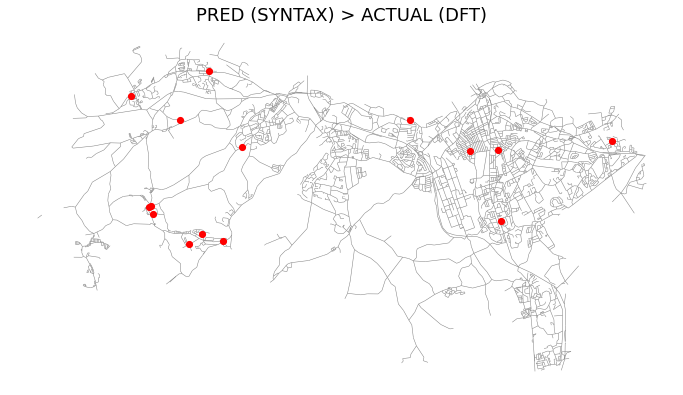

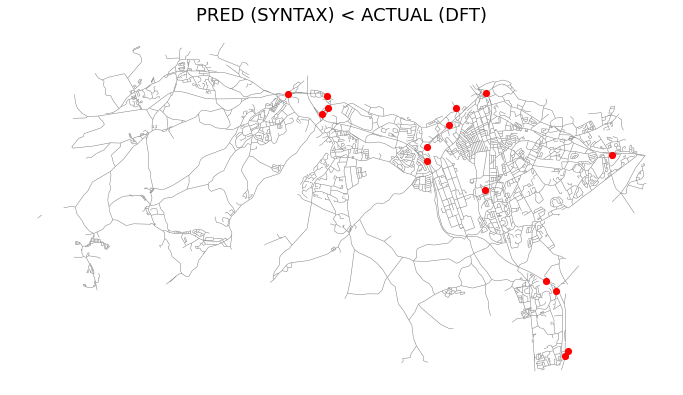

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ss.plot(ax=ax, zorder=1, linewidth=0.5, color="gray")
dft_ss.sort_values(by="resid", ascending=False).head(15)["point"].plot(
    ax=ax, zorder=2, color="r", markersize=32
)
ax.set_title("PRED (SYNTAX) > ACTUAL (DFT)")
ax.axis("off")

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ss.plot(ax=ax, zorder=1, linewidth=0.5, color="gray")
dft_ss.sort_values(by="resid", ascending=True).head(15)["point"].plot(
    ax=ax, zorder=2, color="r", markersize=32
)
ax.set_title("PRED (SYNTAX) < ACTUAL (DFT)")
ax.axis("off")

## Max Space Syntax in Output Area

In [20]:
oa = get_oa_shapes(lad20cd)
oa

,geometry
oa11cd,
E00041363,"POLYGON ((425973.374 561989.125, 425877.956 56..."
E00041364,"POLYGON ((425418.730 562134.331, 425358.711 56..."
E00041366,"POLYGON ((426540.000 562393.000, 426590.000 56..."
E00041367,"POLYGON ((426311.000 562385.221, 426309.862 56..."
E00041368,"POLYGON ((426362.980 561918.501, 426352.333 56..."
...,...
E00170024,"POLYGON ((429641.069 561873.808, 429718.935 56..."
E00170026,"POLYGON ((420439.000 562189.000, 420343.017 56..."
E00170027,"POLYGON ((419475.916 561873.418, 419581.300 56..."


Text(0.5, 1.0, 'E00041860')

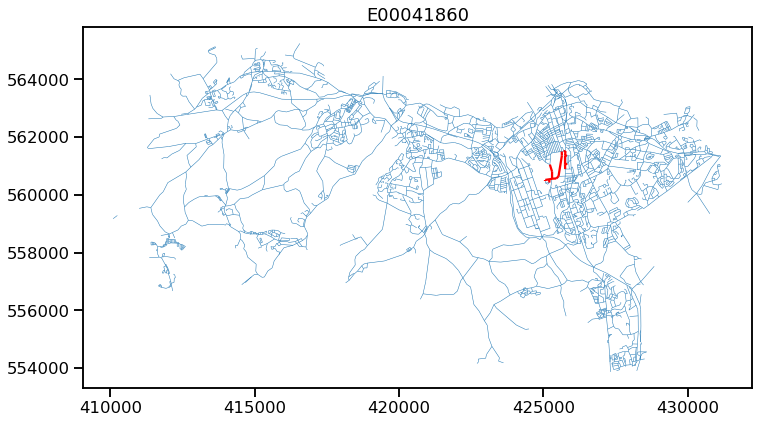

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

test_oa = oa.sample().index[0]
#oa["select"] = False
#oa.loc[test_oa, "select"] = True
#oa.plot(column="select", ax=ax)
#oa.plot(color="None", ax=ax, linewidth=0.5)
ss.plot(ax=ax, linewidth=0.5)
ss[
    ss.crosses(oa.loc[test_oa, "geometry"])
    | ss.within(oa.loc[test_oa, "geometry"])
].plot(color="r", ax=ax)
plt.title(test_oa)

In [22]:
oa["AC__NACH_max"] = [
    ss[
        ss.crosses(oa.loc[oa_name, "geometry"]) | ss.within(oa.loc[oa_name, "geometry"])
    ]["AC__NACH"].max()
    for oa_name in oa.index
]
oa["AC__NACH_max"].fillna(1e-6, inplace=True)
oa["AC__NACH_max"]

oa11cd
E00041363    1.273049
E00041364    1.177554
E00041366    0.900604
E00041367    0.951521
E00041368    1.193292
               ...   
E00170024    0.998511
E00170026    1.197299
E00170027    1.204921
E00170029    1.499886
E00170030    0.998511
Name: AC__NACH_max, Length: 706, dtype: float64

In [23]:
oa_segments = [
    (ss.crosses(oa.loc[oa_name, "geometry"]) | ss.within(oa.loc[oa_name, "geometry"])).sum()
    for oa_name in oa.index
]

In [24]:
oa_segments = pd.Series(oa_segments, index=oa.index)
oa_segments.describe()

count    706.000000
mean      13.053824
std       13.458207
min        0.000000
25%        7.000000
50%       11.000000
75%       16.000000
max      164.000000
dtype: float64

<AxesSubplot:ylabel='Proportion'>

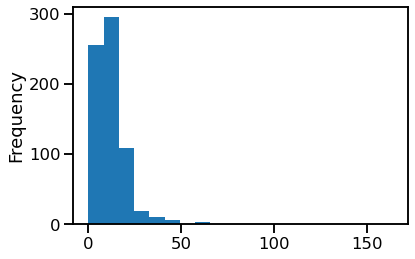

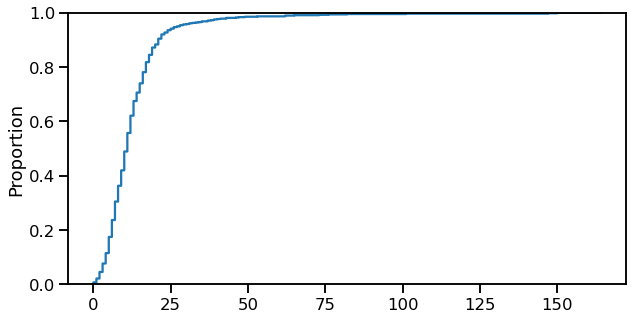

In [25]:
# how many space syntax segments in each oa
oa_segments.plot.hist(bins=20)

plt.figure(figsize=(10, 5))
import seaborn as sns
sns.ecdfplot(oa_segments)

In [26]:
# fix log(NaN) and log(0)
oa["AC__NACH_max"].fillna(1e-6, inplace=True)
oa["AC__NACH_max"].replace(0, 1e-6, inplace=True)

oa["traffic_max"] = np.exp(mdl.predict(np.log(oa["AC__NACH_max"]).values.reshape(-1, 1)))
oa

,geometry,AC__NACH_max,traffic_max
oa11cd,,,
E00041363,"POLYGON ((425973.374 561989.125, 425877.956 56...",1.273049,13629.943162
E00041364,"POLYGON ((425418.730 562134.331, 425358.711 56...",1.177554,8985.154491
E00041366,"POLYGON ((426540.000 562393.000, 426590.000 56...",0.900604,2144.107815
E00041367,"POLYGON ((426311.000 562385.221, 426309.862 56...",0.951521,2876.629843
E00041368,"POLYGON ((426362.980 561918.501, 426352.333 56...",1.193292,9645.822702
...,...,...,...
E00170024,"POLYGON ((429641.069 561873.808, 429718.935 56...",0.998511,3721.823573
E00170026,"POLYGON ((420439.000 562189.000, 420343.017 56...",1.197299,9820.183086
E00170027,"POLYGON ((419475.916 561873.418, 419581.300 56...",1.204921,10158.877313


In [27]:
oa["AC__NACH_max"].describe()

count    706.000000
mean       1.107746
std        0.189577
min        0.000001
25%        1.013974
50%        1.096796
75%        1.214045
max        1.499886
Name: AC__NACH_max, dtype: float64

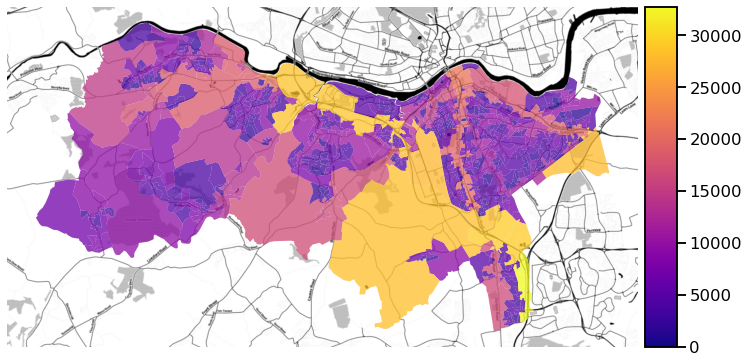

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plot_oa_weights(
    lad20cd,
    oa["traffic_max"],
    vmin=0,
    vmax=None,
    ax=ax
)


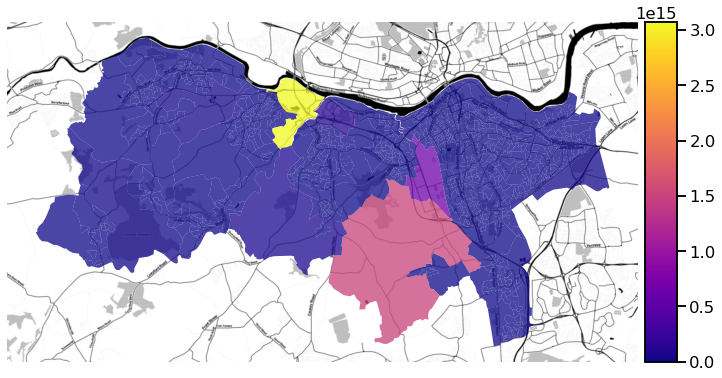

In [59]:
# sum AC_NACH in OA instead of max
oa["AC__NACH_sum"] = [
    ss[
        ss.crosses(oa.loc[oa_name, "geometry"]) | ss.within(oa.loc[oa_name, "geometry"])
    ]["AC__NACH"].sum()
    for oa_name in oa.index
]
oa["AC__NACH_sum"].fillna(1e-6, inplace=True)
oa["AC__NACH_sum"]

# fix log(NaN) and log(0)
oa["AC__NACH_sum"].fillna(1e-6, inplace=True)
oa["AC__NACH_sum"].replace(0, 1e-6, inplace=True)

oa["traffic_sum"] = np.exp(mdl.predict(np.log(oa["AC__NACH_sum"]).values.reshape(-1, 1)))

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plot_oa_weights(
    lad20cd,
    oa["traffic_sum"],
    vmin=0,
    vmax=None,
    ax=ax
)


## Traffic-Optimised Network

In [36]:
n_sensors = 20
theta = 2000

In [37]:
centroids = get_oa_centroids(lad20cd)
oa = oa.join(centroids)
cm =  coverage_matrix(oa["x"], oa["y"], theta=theta)

ValueError: columns overlap but no suffix specified: Index(['x', 'y'], dtype='object')

In [39]:
r = greedy_opt(n_sensors, cm, oa["traffic_max"].values)

r = make_result_dict(
    lad20cd,
    n_sensors,
    theta,
    oa["x"].values,
    oa["y"].values,
    oa.index,
    r["sensors"],
    r["total_coverage"],
    r["point_coverage"],
    list(oa.index[r["placement_history"]]),
    r["coverage_history"],
    oa_weight=r["weights"],
    pop_age_groups={},
    population_weight=0,
    workplace_weight=0,
)

Placing sensor 1 out of 20 ... coverage = 0.26
Placing sensor 2 out of 20 ... coverage = 0.33
Placing sensor 3 out of 20 ... coverage = 0.39
Placing sensor 4 out of 20 ... coverage = 0.45
Placing sensor 5 out of 20 ... coverage = 0.49
Placing sensor 6 out of 20 ... coverage = 0.53
Placing sensor 7 out of 20 ... coverage = 0.57
Placing sensor 8 out of 20 ... coverage = 0.59
Placing sensor 9 out of 20 ... coverage = 0.62
Placing sensor 10 out of 20 ... coverage = 0.63
Placing sensor 11 out of 20 ... coverage = 0.65
Placing sensor 12 out of 20 ... coverage = 0.66
Placing sensor 13 out of 20 ... coverage = 0.67
Placing sensor 14 out of 20 ... coverage = 0.69
Placing sensor 15 out of 20 ... coverage = 0.70
Placing sensor 16 out of 20 ... coverage = 0.70
Placing sensor 17 out of 20 ... coverage = 0.71
Placing sensor 18 out of 20 ... coverage = 0.72
Placing sensor 19 out of 20 ... coverage = 0.73
Placing sensor 20 out of 20 ... coverage = 0.74


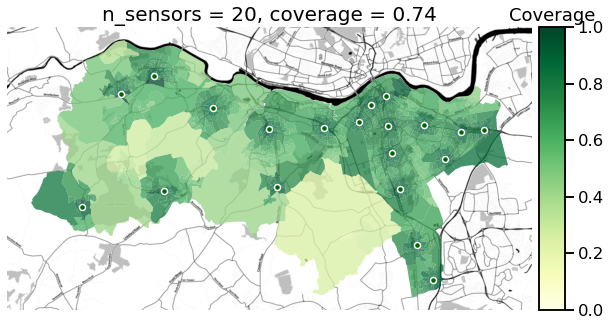

In [40]:
plot_optimisation_result(r)

Placing sensor 1 out of 20 ... coverage = 0.05
Placing sensor 2 out of 20 ... coverage = 0.08
Placing sensor 3 out of 20 ... coverage = 0.11
Placing sensor 4 out of 20 ... coverage = 0.14
Placing sensor 5 out of 20 ... coverage = 0.16
Placing sensor 6 out of 20 ... coverage = 0.18
Placing sensor 7 out of 20 ... coverage = 0.20
Placing sensor 8 out of 20 ... coverage = 0.22
Placing sensor 9 out of 20 ... coverage = 0.24
Placing sensor 10 out of 20 ... coverage = 0.25
Placing sensor 11 out of 20 ... coverage = 0.27
Placing sensor 12 out of 20 ... coverage = 0.28
Placing sensor 13 out of 20 ... coverage = 0.30
Placing sensor 14 out of 20 ... coverage = 0.31
Placing sensor 15 out of 20 ... coverage = 0.32
Placing sensor 16 out of 20 ... coverage = 0.33
Placing sensor 17 out of 20 ... coverage = 0.34
Placing sensor 18 out of 20 ... coverage = 0.35
Placing sensor 19 out of 20 ... coverage = 0.36
Placing sensor 20 out of 20 ... coverage = 0.37


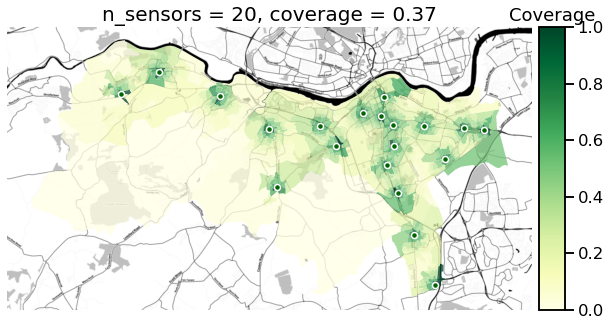

In [35]:
theta = 500
cm =  coverage_matrix(oa["x"], oa["y"], theta=theta)
r = greedy_opt(n_sensors, cm, oa["traffic_max"].values)
r = make_result_dict(
    lad20cd,
    n_sensors,
    theta,
    oa["x"].values,
    oa["y"].values,
    oa.index,
    r["sensors"],
    r["total_coverage"],
    r["point_coverage"],
    list(oa.index[r["placement_history"]]),
    r["coverage_history"],
    oa_weight=r["weights"],
    pop_age_groups={},
    population_weight=0,
    workplace_weight=0,
)
plot_optimisation_result(r)

In [33]:
r = optimise(
    lad20cd=lad20cd,
    n_sensors=n_sensors,
    theta=theta,
    population_weight=0,
    workplace_weight=0,
    traffic_weight=1,
)
plot_optimisation_result(r)

Fetching data...
No traffic data found at /Users/jroberts/GitHub/spatial-inequality/spineq/../data/processed/E08000037/traffic.csv


/Users/jroberts/GitHub/spatial-inequality/spineq/data_fetcher.py:472: UserWarning: No traffic data found at /Users/jroberts/GitHub/spatial-inequality/spineq/../data/processed/E08000037/traffic.csv
  warnings.warn(f"No {key} data found at {full_path}")


KeyError: 'traffic'